# Hyperparameter Tuning

In [49]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, validation_curve, GridSearchCV

In [15]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [16]:
X = df.loc[:, 2:].values # 30 features
y = df.loc[:, 1].values # target variables

le = LabelEncoder()
y = le.fit_transform(y)

print(le.classes_)
print(le.transform(['M', 'B']))

['B' 'M']
[1 0]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1) # 80/20 train/test split

We will be using LinearRegression on the breast cancer dataset. Before we train the model, we want to scale the features as well as reduce dimensionality with PCA. Instead of doing each step one at a time, like we have done in previous assignments, we will use a pipeline to combine the steps.

In [25]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(solver='liblinear', random_state=1))
pipe_lr.fit(X_train, y_train)

print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


The pipeline wrapper is useful, as it allows us to combine multiple steps into a single estimator, having it run fit & transform for each step in the training. Then during prediction, it will run transform for the scaling & dimensionality step, and then predict for the final model step.

## K-Fold Cross Validation

In [27]:
# Verbouse code for k-fold cross-validation
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


In [34]:
# Sci-kit learn cross-validation function
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


## Learning & Validation Curves

### Model training & evaluation accuracy over number of training samples

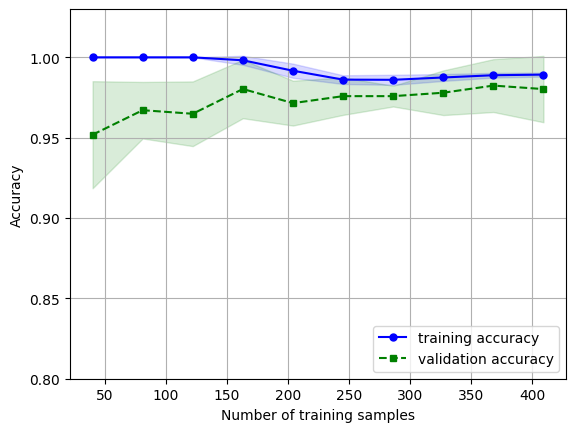

In [38]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', solver='liblinear', random_state=1))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

### Addressing over- and underfitting with validation curves

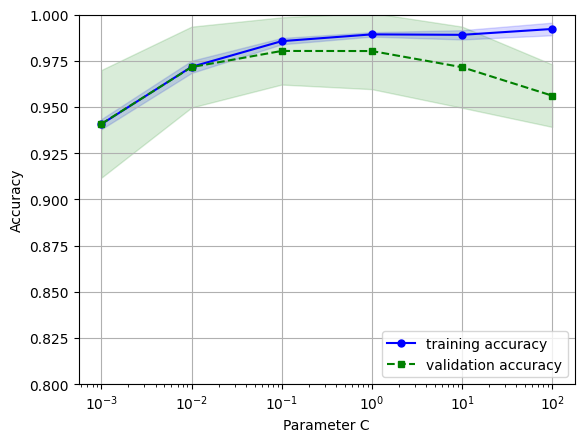

In [41]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # Regularization parameter
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

As we can see, when regularization is high (low C value) the model tends to underfit a bit. With low regularization (high C value) the model tends to overfit. The best setting seems to be somewhere around .001 and .01.

## Hyperparameter Tuning with Grid Search

In [44]:
# Grid Search is a brute-force exhaustive search paradigm where we specify a list of values for different hyperparameters, and the computer evaluates the model performance for each combination of those to obtain the optimal set of hyperparameters
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# Linear kernal vs RBF kernel (non-linear data)
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [47]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


While GridSearchCV is great, the brute force nature of trying every single combination can be pretty computationally expensive. Another search algorithm to look into is RandomizedSearchCV, which is a more efficient way to search through hyperparameters. For example, by sampling 60 parameter combinations, we can have a 95% chance of finding solutions within 5% of the best solution.

## Algorithm selection with nested cross-validation